
# 4.7. Mapping data between Python and MATLAB

In his book about [*Python for MATLAB Development*](https://link.springer.com/book/10.1007/978-1-4842-7223-7), Albert Danial shares some clever functions to convert MATLAB variables into an equivalent Python-native variable with [<u>mat2py</u>](https://github.com/Apress/python-for-matlab-development/blob/main/code/matlab_py/mat2py.m), and vice-versa with [<u>py2mat</u>](https://github.com/Apress/python-for-matlab-development/blob/main/code/matlab_py/py2mat.m).


[Converting data](https://www.mathworks.com/help/matlab/matlab_external/passing-data-to-python.html) returned by Python function inside of MATLAB may require understanding some of the differences in the native datatypes of the two languages:

   -  Scalars (integers, floating point numbers, …), text and Booleans
   -  Dictionaries and lists
   -  Arrays and dataframes


Some specialized MATLAB data types like *timetable* or *categorical* will require some extra love and need to be converted manually. Of course, we can still use these data types in our functions, but the functions need to return types that the Python interpreter can understand.

## 4.7.1. Scalars

The table below shows the mappings for common scalar data types:


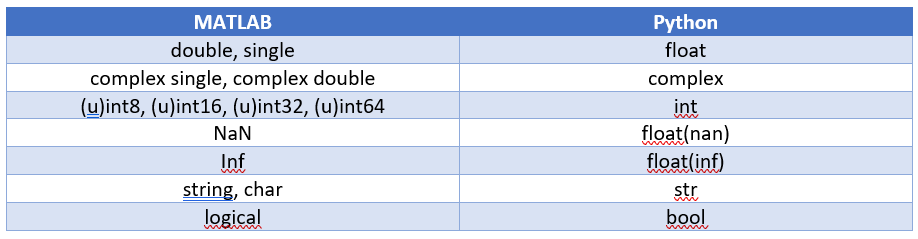


By default, numbers in MATLAB are double, whereas numbers without decimal point in Python are integers.


In [1]:
a = py.dataExchange.get_float()

In [2]:
class(a)

In [3]:
b = py.dataExchange.get_complex()

In [4]:
class(b)


There are several kinds of integers in MATLAB, depending on the precision you require.


For instance [uint8](https://www.mathworks.com/help/matlab/ref/uint8.html) can only store positive numbers between 0 and 255, whereas [int8](https://www.mathworks.com/help/matlab/ref/int8.html) covers the range [-2^7,2^7-1]


The most generic type to convert Python integers are int64, which you can do explicitely


In [5]:
c = py.dataExchange.get_integer()

In [6]:
class(c)

In [7]:
int64(c)


When getting a string from a Python function, the convertion isn't obvious. It can either be turned into a [char](https://www.mathworks.com/help/matlab/ref/char.html) (character array) or a [string](https://www.mathworks.com/help/matlab/ref/string.html).


You can distinguish them by the single quotation marks for chars, and double quotes for strings.


In [8]:
abc = py.dataExchange.get_string()

In [9]:
char(abc)

In [10]:
class(char(abc))

In [11]:
string(abc)

In [12]:
class(string(abc))


Finally, the last basic datatype that contains a logical information is called a boolean in Python:


In [13]:
py.dataExchange.get_boolean()

## 4.7.2. Dictionaries and Lists

This is how containers map to each other between the two languages:


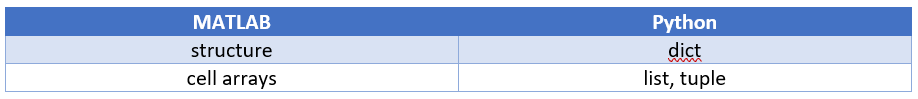


To illustrate the conversion of Python dictionaries and lists into MATLAB containers, we will reuse the example from chapter 2.


JSON data are really close to dictionaries in Python, which makes the data processing very easy when accessing data from web services.


In [14]:
url = webread("https://samples.openweathermap.org").products.current_weather.samples{1};
r = py.urllib.request.urlopen(url).read();
json_data = py.json.loads(r);
py.weather.parse_current_json(json_data)


Dictionaries can contain scalars, but also other datatypes like lists.


In [15]:
url2 = webread("https://samples.openweathermap.org").products.forecast_5days.samples{1};
r2 = py.urllib.request.urlopen(url2).read();
json_data2 = py.json.loads(r2);
forecast = struct(py.weather.parse_forecast_json(json_data2))

In [16]:
forecastTemp = forecast.temp;
forecastTime = forecast.current_time;


Lists containing only numeric data can be converted into doubles since MATLAB R2022a:


In [17]:
double(forecastTemp)


And any lists can be converted to string (even those containing a mix of text and numeric data).


In [18]:
forecastTimeString = string(forecastTime);
datetime(forecastTimeString)


Before MATLAB R2022a, Python lists need to be converted into [MATLAB cell arrays](https://www.mathworks.com/help/matlab/cell-arrays.html).


Cells can then be transformed to double, strings, with the [cellfun](https://www.mathworks.com/help/matlab/ref/cellfun.html) function.


The previous code would look like this until R2021b:


In [19]:
forecastTempCell = cell(forecastTemp)

In [20]:
cellfun(@double,forecastTempCell)

In [21]:
forecastTimeCell = cell(forecastTime)

In [22]:
cellfun(@string,forecastTimeCell)

## 4.7.3. Arrrays

By modifying the parse_forecast_json function in the weather module, we can output [Python arrays](https://docs.python.org/3/library/array.html) instead of lists.


There exists indeed a native array datatype in base Python.


In [23]:
forecast2 = struct(py.weather.parse_forecast_json2(json_data2))


The MATLAB double function will convert the Python array into a MATLAB array


In [24]:
double(forecast2.temp)


Those data conversion also apply to Numpy arrays:


In [25]:
npA = py.numpy.array([1,2,3;4,5,6;7,8,9])

In [26]:
double(npA)

## 4.7.4. Dataframes

One common question on data transfer, is how to exchange data between MATLAB tables and Pandas Dataframes. The recommended solution for that is to rely on [Parquet files](https://www.mathworks.com/help/matlab/parquet-files.html). Parquet is a columnar storage format that enables to store & transfer tabular data between languages. It is available to any project in the Hadoop big data ecosystem, regardless of the choice of data processing framework, data model or programming language (more on [Parquet](https://parquet.apache.org/)).


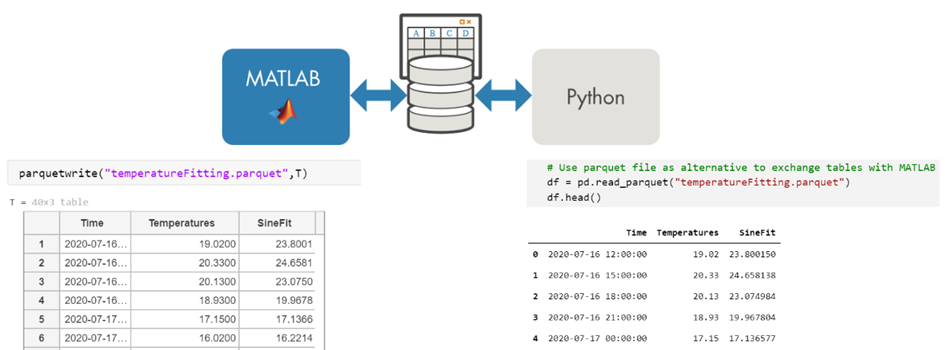


This example demonstrates a back and forth between Pandas DataFrames and MATLAB Tables:


<u>**pq_CreateDataFrame.py**</u>

<pre>
import pandas as pd
import numpy as np

# create dataframe
df = pd.DataFrame({'column1': [-1, np.nan, 2.5],
'column2': ['foo', 'bar', 'tree'],
'column3': [True, False, True]})
print(df)

# save dataframe to parquet file via pyarrow library
df.to_parquet('data.parquet', index=False)
</pre>


Read in parquet file


In [27]:
% info = parquetinfo('data.parquet')
data = parquetread('data.parquet')


Examine datatype of a particular column


In [28]:
class(data.column2)


Change data in table


In [29]:
data.column2 = ["orange"; "apple"; "banana"];


Write the results back to parquet


In [30]:
parquetwrite('newdata.parquet', data)


Finally read the modified DataFrame back in Python:


<u>**pq_ReadTable.py**</u>

<pre>
import pandas as pd
import os
# change to current directory
thisDirectory = os.path.dirname(os.path.realpath(__file__))
os.chdir(thisDirectory)
# read parquet file via pyarrow library
df = pd.read_parquet('newdata.parquet')
print(df)
</pre>
